In [1]:
### Following code uses movement_primitives and gmr packages
### To install the packages, run the following commands on Python>3.6:
### pip install movement_primitives[all]
### pip install gmr[all]

from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import numpy as np
import matplotlib.pyplot as plt


x = np.arange(0,1.00,0.01)
nrTraj=30
sigmaNoise=0.02

A = np.array([.2, .2, .01, -.05])
X = np.vstack((np.sin(5*x), x**2, x, np.ones((1,len(x)))))
Y = np.zeros((nrTraj, len(x)))

for traj in range(nrTraj):
    sample = np.dot(A + sigmaNoise * np.random.randn(1,4), X)[0]
    Y[traj] = sample
#    label = 'training' if traj==0 else ''
#     plt.plot(x, sample, 'b', label=label)

# plt.legend()
# plt.title('Demonstrations')

In [2]:
msp = np.mean(Y[:, 0])   # Average start
mep = np.mean(Y[:, -1])   # Average end

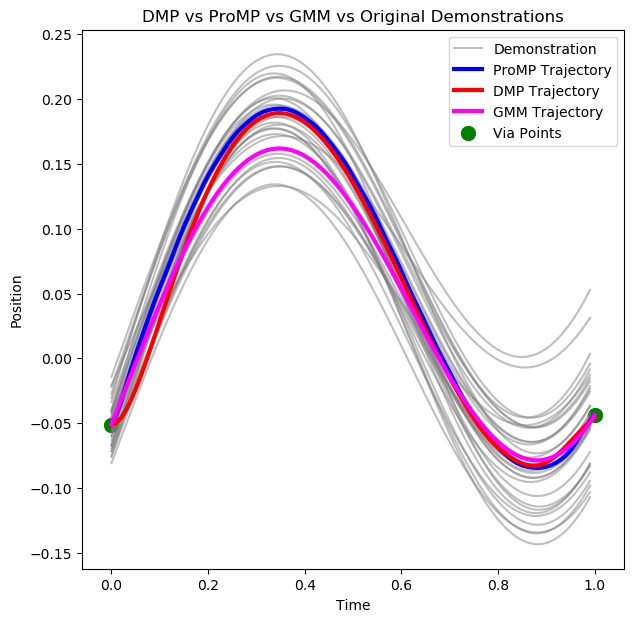

In [3]:
d = DMP(n_dims=1, n_weights_per_dim=20)

plt.rcParams['figure.figsize'] = [7, 7]

for i, traj in enumerate(Y):
    d.imitate(x, traj.reshape(-1,1))
    plt.plot(x, traj, color='gray', label='Demonstration' if i==0 else '', alpha=0.5)  # Original trajectories in gray

d.configure(start_y=[msp], goal_y=[mep])
t, trajectory = d.open_loop()

p = ProMP(n_dims=1, n_weights_per_dim=20)
p.imitate(np.tile(x, (30, 1)), Y)

p = p.condition_position(msp, t=0).condition_position(mep, t=1)

trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

input_data = x.reshape(-1, 1)  # Phase variable as a column vector
output_data = Y

priors = 20  # Number of GMM components
gmr_model = GMM(n_components=priors, random_state=1234)
gmr_model.from_samples(Y)
gmr_model = gmr_model.condition([0, -1], [msp, mep])
trajectory_g = gmr_model.sample(1)
trajectory_g = np.insert(trajectory_g, 0, msp)
trajectory_g = np.append(trajectory_g, mep)

plt.plot(x, trajectory_p[0,:,0], label='ProMP Trajectory', color='blue', linewidth=3)
plt.plot(t, trajectory, label='DMP Trajectory', color='red', linewidth=3)
plt.plot(x, trajectory_g, label='GMM Trajectory', color='magenta', linewidth=3)

plt.scatter([0, 1], [msp, mep], color='green', label='Via Points', s=100)  # Via points
plt.legend(loc='best')
plt.title('DMP vs ProMP vs GMM vs Original Demonstrations')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()

In [4]:
print(x.shape, Y.shape)

np.save('/home/yigit/Desktop/y_single.npy', Y)
np.save('/home/yigit/Desktop/x_single.npy', x)

(100,) (30, 100)
